# Modeling

Here I'll try to create a model which can predict a better results.<br>
**Better results** ==
1. The model should predict as many churned customers as possible.
2. FN (False Negative) must be low
3. Recall is important here and must be high
* If model's F1 score is high, then the model is doing well all around.

In [27]:
# import important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve, auc, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
#from xgboost import XGBClassifier
#import xgboost as xgb 
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier

# if we want to see all columns, we set this parametr on
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# use custom function
%run -i 'py/dataframecheck.py'
%run -i 'py/models_check.py'

# set style for plots
sns.set(style="whitegrid")

### Some function for faster work

In [3]:
# print information on the screen
def evaluate_predictions(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):
# Evaluate predictions
    print('-'*40)
    print('Accuracy score for Training Dataset = ', accuracy_score(y_train, y_hat_train))
    print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, y_hat_test))

    print('-'*40)
    print('------------Confusion Matrix------------')
    print('Train set:')
    print(confusion_matrix(y_train, y_hat_train), '\n')
    print('Test set:')
    print(confusion_matrix(y_test, y_hat_test), '\n')

    print('-'*40)
    print('---------Classification Matrix:---------')
    print('Train set:')
    print(classification_report(y_train, y_hat_train), '\n')
    print('Test set:')
    print(classification_report(y_test, y_hat_test))

---------
### Prepare data for modeling:
1. Read data set and check it.

In [5]:
# read dataset
df = pd.read_csv("data/mod_churn.csv")
df.head(3)

,seniorcitizen,partner,dependents,tenure,multiplelines,internetservice,onlinebackup,deviceprotection,techsupport,streamingtv,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,0,Yes,No,1,No phone service,DSL,Yes,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,0,No,No,34,No,DSL,No,Yes,No,No,One year,No,Mailed check,56.95,1889.50,0
2,0,No,No,2,No,DSL,Yes,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1


In [4]:
print('List of columns for modeling:')
list(df.columns)

List of columns for modeling:


['seniorcitizen',
 'partner',
 'dependents',
 'tenure',
 'multiplelines',
 'internetservice',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'monthlycharges',
 'totalcharges',
 'churn']

2. **One hot encoding:** To prepare the dataset for modeling, I need to encode categorical features to numbers. This means encoding "Yes"/"No" to 0/1

In [6]:
# One-hot encode
df = pd.get_dummies(df, 
                    columns=['seniorcitizen', 'partner', 'dependents',
                             'multiplelines', 'internetservice', 'onlinebackup', 'deviceprotection',
                             'techsupport', 'streamingtv', 'contract', 'paperlessbilling', 'paymentmethod'], 
                    drop_first=True)

In [6]:
df.tail(3)

,tenure,monthlycharges,totalcharges,churn,seniorcitizen_1,partner_Yes,dependents_Yes,multiplelines_No phone service,multiplelines_Yes,internetservice_Fiber optic,internetservice_No,onlinebackup_No internet service,onlinebackup_Yes,deviceprotection_No internet service,deviceprotection_Yes,techsupport_No internet service,techsupport_Yes,streamingtv_No internet service,streamingtv_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
7029,11,29.60,346.45,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
7030,4,74.40,306.60,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
7031,66,105.65,6844.50,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0


In [7]:
list(df.columns)

['tenure',
 'monthlycharges',
 'totalcharges',
 'churn',
 'seniorcitizen_1',
 'partner_Yes',
 'dependents_Yes',
 'multiplelines_No phone service',
 'multiplelines_Yes',
 'internetservice_Fiber optic',
 'internetservice_No',
 'onlinebackup_No internet service',
 'onlinebackup_Yes',
 'deviceprotection_No internet service',
 'deviceprotection_Yes',
 'techsupport_No internet service',
 'techsupport_Yes',
 'streamingtv_No internet service',
 'streamingtv_Yes',
 'contract_One year',
 'contract_Two year',
 'paperlessbilling_Yes',
 'paymentmethod_Credit card (automatic)',
 'paymentmethod_Electronic check',
 'paymentmethod_Mailed check']

In [7]:
df.shape

(7032, 25)

## Base line model

To choose the baseline model, I will check first the best model report where I can put all main models' parameters. Report has the next steps:
1. create a dataframe for models' parameters;
2. split data for modeling;
3. scale data (my dataset imbalenced and this step prevent error for ML atgorithms: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance));
4. use simple model classifier without any special variables for dataset.

In [9]:
model_report_fit(df)

,Model,Accuracy_score,Recall_score,Precision,f1_score,AUC
0,Logistic Regression,0.799858,0.536137,0.660194,0.591733,0.716899
1,Decision Tree,0.715606,0.480946,0.474708,0.477807,0.641789
2,KNN Classifier,0.749733,0.508541,0.539749,0.523681,0.673861
3,Random Forest Classifier,0.777106,0.459921,0.618375,0.527506,0.677329
4,SVM Classifier Linear,0.793103,0.519054,0.646481,0.575802,0.706895
5,AdaBoost Classifier,0.793459,0.486202,0.660714,0.560182,0.696805


My dataset has a lot of 0 and 1, I expected good results for Decision Tree Model. But using this preliminary result I decided to concentrate on Logistic Regression, Random Forest Classifier, SVM Classifier Linear and try
AdaBoost Classifier (if I have time).

In [10]:
# min-max scaling for normalize columns MinMaxScaler
df_m = df.fillna(value=0) 
for col in df_m.columns:
    df_m[col] = (df_m[col] - min(df_m[col]))/ (max(df_m[col]) - min(df_m[col])) 

df_m.head()

,tenure,monthlycharges,totalcharges,churn,seniorcitizen_1,partner_Yes,dependents_Yes,multiplelines_No phone service,multiplelines_Yes,internetservice_Fiber optic,internetservice_No,onlinebackup_No internet service,onlinebackup_Yes,deviceprotection_No internet service,deviceprotection_Yes,techsupport_No internet service,techsupport_Yes,streamingtv_No internet service,streamingtv_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,0.000000,0.115423,0.001275,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.464789,0.385075,0.215867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.014085,0.354229,0.010310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.619718,0.239303,0.210241,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.014085,0.521891,0.015330,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## Create a baseline model

In [11]:
# Splitting the data into test and train sets
X = df.drop(['churn'], axis=1)
y = df['churn']

In [12]:
# Split data into X and y
y=df['churn'].copy()

# Define X
X = df.drop(columns=['churn'], axis=1)

# Split the data into a training and a test set and set stratify=y to help with imbalance data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## LogisticRegression
I'll start my modeling with simple models. I have information with all defaul parameters, now check another:
* 'fit_intercept=False' - Specifies if a constant (bias or intercept) should be added to the decision function (default=True).
* C=1e10 - Inverse of regularization strength; must be a positive float. 
Like in support vector machines, smaller values specify stronger regularization.
* solver='liblinear' - Algorithm to use in the optimization problem, can be ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’, and default=’lbfgs’.
* class_weight='balanced' - Weights associated with classes. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as 'n_samples / (n_classes * np.bincount(y))'

In [13]:
# modeling with LogesticRegression
# create an instance and fit the model 
base_logmodel = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', class_weight='balanced')
base_logmodel.fit(X_train, y_train)

#predictions
y_hat_train = base_logmodel.predict(X_train)
y_hat_test = base_logmodel.predict(X_test)

evaluate_predictions(X_train, X_test, y_train, y_test, y_hat_train, y_hat_test)

----------------------------------------
Accuracy score for Training Dataset =  0.7538869927948426
Accuracy score for Testing Dataset =  0.735494880546075
----------------------------------------
------------Confusion Matrix------------
Train set:
[[2837 1026]
 [ 272 1139]] 

Test set:
[[932 368]
 [ 97 361]] 

----------------------------------------
---------Classification Matrix:---------
Train set:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      3863
           1       0.53      0.81      0.64      1411

    accuracy                           0.75      5274
   macro avg       0.72      0.77      0.73      5274
weighted avg       0.81      0.75      0.77      5274
 

Test set:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1300
           1       0.50      0.79      0.61       458

    accuracy                           0.74      1758
   macro avg       0.70      0.75     

In [15]:
# Compute Receiver operating characteristic (ROC)
# Calculate the probability scores of each point in the training set
y_train_score = base_logmodel.fit(X_train, y_train).decision_function(X_train)

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

# Calculate the probability scores of each point in the test set
y_test_score = base_logmodel.decision_function(X_test)

# Calculate the fpr, tpr, and thresholds for the test set
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
# probability that a randomly chosen positive instance is ranked higher 
# than a randomly chosen negative instance
print('Training AUC: {}'.format(round(auc(train_fpr, train_tpr), 5)))
print('Testing AUC: {}'.format(round(auc(test_fpr, test_tpr), 5)))

Training AUC: 0.84942
Testing AUC: 0.83321


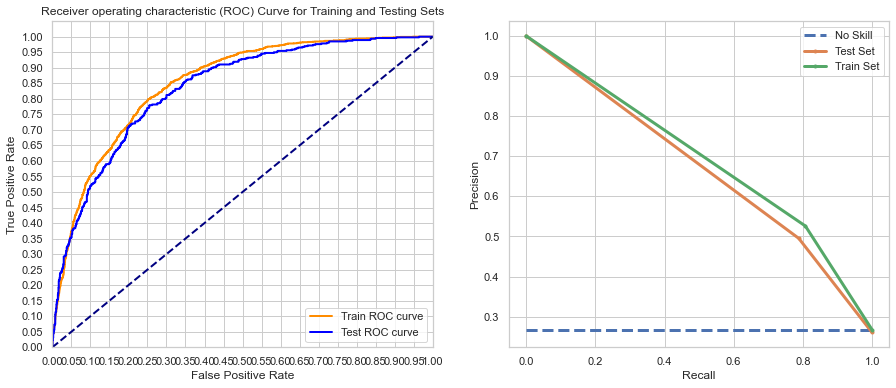

In [27]:
# ROC curve for training set
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='blue',
             lw=lw, label='Test ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(
        'Receiver operating characteristic (ROC) Curve for Training and Testing Sets')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
lw =3
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', lw = lw, label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_hat_test)
train_precision, train_recall, _ = precision_recall_curve(y_train, y_hat_train)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', lw = lw, label='Test Set')
plt.plot(train_recall,train_precision, marker='.',lw=lw, label='Train Set')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()

# show the plot
plt.show()

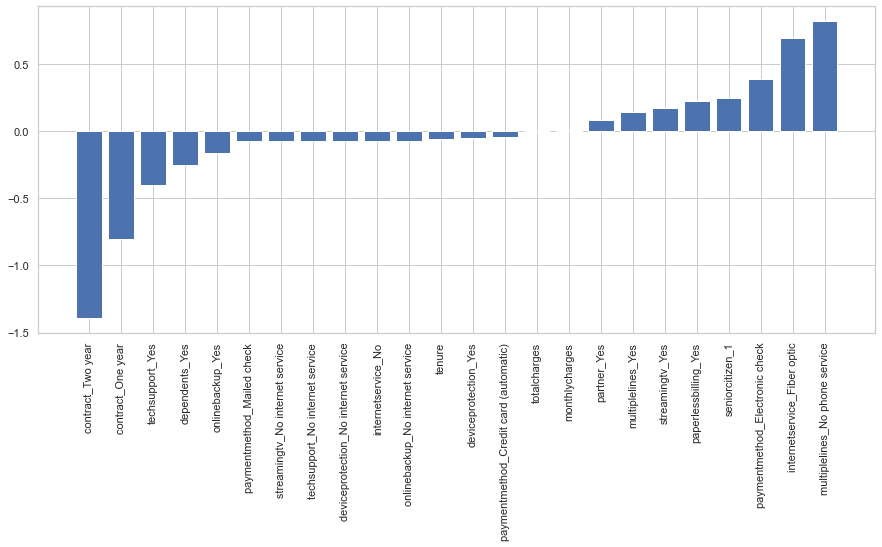

In [26]:
weights_LogReg = pd.Series(base_logmodel.coef_[0], index=X.columns.values)
weights_LogReg.sort_values(inplace=True)
plt.figure(figsize=(15, 6))
plt.xticks(rotation=90)
features=plt.bar(weights_LogReg.index,weights_LogReg.values)

As we can see, some variables are negatively correlated with the predicted variable (Churn), while some have positively. Negative correlation means that likeliness of churn decreases with that variable.

Let me interpret some findings from above plot,

As we have seen in our EDA, having a 2 month contract reduces chances of churn. 2 month contract along with tenure have the most negative relation with Churn as predicted by logistic regressions.
Total charges, monthly contracts, fibre optic internet services and seniority can lead to higher churn rates. This is interesting because although fibre optic services are faster, customers are likely to churn because of it.
I don't understad why this is happening.

Till the time let's have a look at other algorithms.

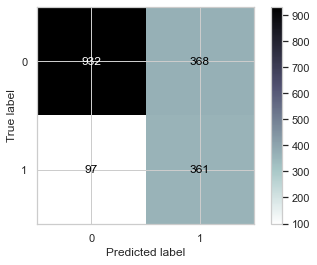

In [28]:
plot_confusion_matrix(base_logmodel, X_test, y_test,cmap='bone_r') 

### Conclusion
Based on the model evaluation metrics,plots, and coefficients: the results are not bad for a baseline model.<br>
Here we can see:
1. The basemodel with logistic regression has an accuracy of 75,4% for training data and 73.4% for testing.
2. The basemodel recall is 79% with false negative pecentage of 97/458 =21%. 
3. The target is imbalanced, I'll try to fixe it through smote. 
--------------

# Synthetic sample for basemodel

In [35]:
smote = SMOTE()
# adasyn = ADASYN()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

-----------------------------------------
Synthetic sample class distribution: 

1    3863
0    3863
Name: churn, dtype: int64


Check how SMOTE change model evaluation.

In [37]:
smote_logmodel = LogisticRegression(fit_intercept=False, C=1e12,
                         solver='liblinear', class_weight='balanced')
smote_logmodel.fit(X_train_resampled, y_train_resampled)

#predictions
y_hat_train = smote_logmodel.predict(X_train_resampled)
y_hat_test = smote_logmodel.predict(X_test)

evaluate_predictions(X_train_resampled, X_test, y_train_resampled, y_test, y_hat_train, y_hat_test)

----------------------------------------
Accuracy score for Training Dataset =  0.8160755889205281
Accuracy score for Testing Dataset =  0.7554038680318543
----------------------------------------
------------Confusion Matrix------------
Train set:
[[3007  856]
 [ 565 3298]] 

Test set:
[[1007  293]
 [ 137  321]] 

----------------------------------------
---------Classification Matrix:---------
Train set:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      3863
           1       0.79      0.85      0.82      3863

    accuracy                           0.82      7726
   macro avg       0.82      0.82      0.82      7726
weighted avg       0.82      0.82      0.82      7726
 

Test set:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1300
           1       0.52      0.70      0.60       458

    accuracy                           0.76      1758
   macro avg       0.70      0.74

In [40]:
# Compute Receiver operating characteristic (ROC)
# Calculate the probability scores of each point in the training set
y_train_score = smote_logmodel.fit(X_train, y_train).decision_function(X_train)

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

# Calculate the probability scores of each point in the test set
y_test_score = smote_logmodel.decision_function(X_test)

# Calculate the fpr, tpr, and thresholds for the test set
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
# probability that a randomly chosen positive instance is ranked higher 
# than a randomly chosen negative instance
print('Training AUC: {}'.format(round(auc(train_fpr, train_tpr), 5)))
print('Testing AUC: {}'.format(round(auc(test_fpr, test_tpr), 5)))

Training AUC: 0.84942
Testing AUC: 0.83321


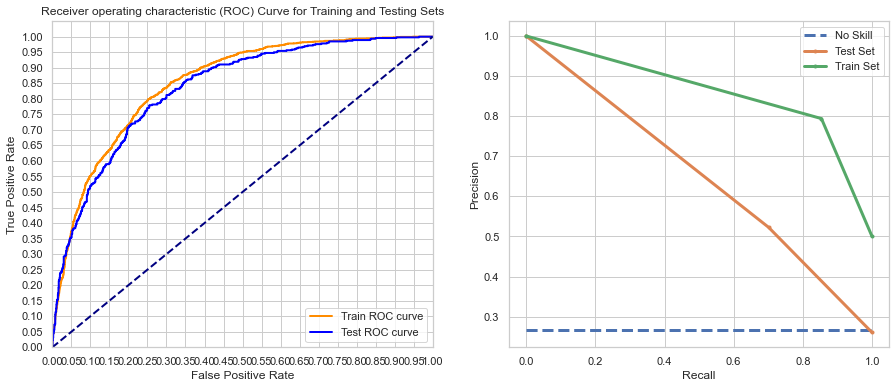

In [42]:
# ROC curve for training set
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='blue',
             lw=lw, label='Test ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(
        'Receiver operating characteristic (ROC) Curve for Training and Testing Sets')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
lw =3
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', lw = lw, label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_hat_test)
train_precision, train_recall, _ = precision_recall_curve(y_train_resampled, y_hat_train)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', lw = lw, label='Test Set')
plt.plot(train_recall,train_precision, marker='.',lw=lw, label='Train Set')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()

# show the plot
plt.show()

We can see how smoting affects to model, but it did model better.
Here can see that this model got better results in precision and recall, but there is overfitting. I can't use these results for applied to other datasets.

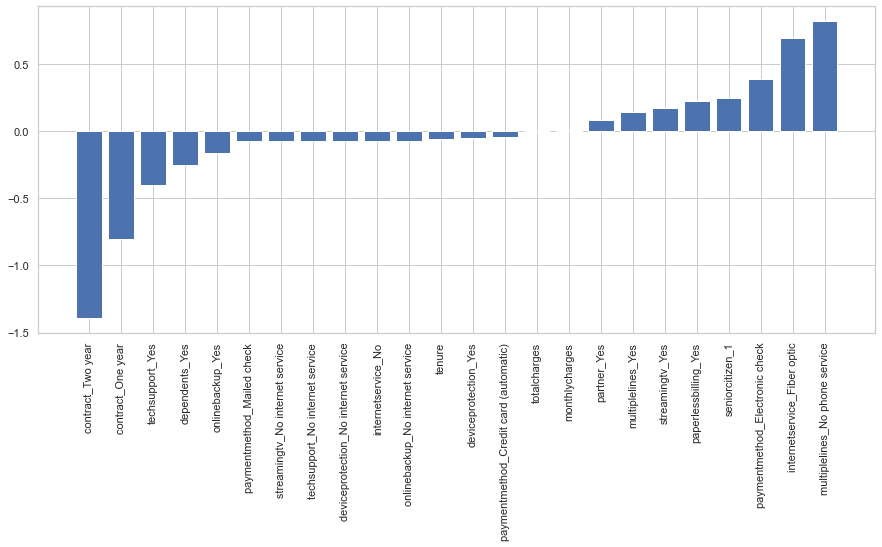

In [43]:
# To get the weights of all the variables
weights_model = pd.Series(smote_logmodel.coef_[0], index=X.columns.values)
weights_model.sort_values(inplace=True)
plt.figure(figsize=(15, 6))
plt.xticks(rotation=90)
features = plt.bar(weights_model.index, weights_model.values)

In [45]:
# Grid search for Logistic regression 
lr = LogisticRegression()
param_grid = {
    "penalty": ['l1','l2'],
    'C': [100, 10, 1, 0.1, 0.01, 0.001],
    'fit_intercept': [False,True],
    'random_state': [11,70,80],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'lbfgs'],
    'max_iter': [200],
    ''
}
grid_clf = GridSearchCV(lr, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_clf.fit(X_train_resampled, y_train_resampled)

grid_clf.best_params_

{'C': 0.1,
 'fit_intercept': True,
 'max_iter': 200,
 'penalty': 'l2',
 'random_state': 11,
 'solver': 'liblinear'}

In [62]:
'''
{'C': 0.1,
 'fit_intercept': True,
 'max_iter': 200,
 'penalty': 'l2',
 'random_state': 11,
 'solver': 'liblinear'}
'''

grid_logmodel = LogisticRegression(fit_intercept=True, C=0.1,max_iter=200,penalty='l2',random_state=11,
                         solver='liblinear', class_weight='balanced')
grid_logmodel.fit(X_train, y_train)

#predictions
y_hat_train = grid_logmodel.predict(X_train)
y_hat_test = grid_logmodel.predict(X_test)

evaluate_predictions(X_train, X_test, y_train, y_test, y_hat_train, y_hat_test)

----------------------------------------
Accuracy score for Training Dataset =  0.7565415244596132
Accuracy score for Testing Dataset =  0.7417519908987485
----------------------------------------
------------Confusion Matrix------------
Train set:
[[2862 1001]
 [ 283 1128]] 

Test set:
[[946 354]
 [100 358]] 

----------------------------------------
---------Classification Matrix:---------
Train set:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      3863
           1       0.53      0.80      0.64      1411

    accuracy                           0.76      5274
   macro avg       0.72      0.77      0.73      5274
weighted avg       0.81      0.76      0.77      5274
 

Test set:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1300
           1       0.50      0.78      0.61       458

    accuracy                           0.74      1758
   macro avg       0.70      0.75    

In [69]:
# Compute Receiver operating characteristic (ROC)
# Calculate the probability scores of each point in the training set
y_train_score = grid_logmodel.fit(X_train, y_train).decision_function(X_train)

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

# Calculate the probability scores of each point in the test set
y_test_score = grid_logmodel.decision_function(X_test)

# Calculate the fpr, tpr, and thresholds for the test set
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
# probability that a randomly chosen positive instance is ranked higher 
# than a randomly chosen negative instance
print('Training AUC: {}'.format(round(auc(train_fpr, train_tpr), 5)))
print('Testing AUC: {}'.format(round(auc(test_fpr, test_tpr), 5)))

Training AUC: 0.84628
Testing AUC: 0.831


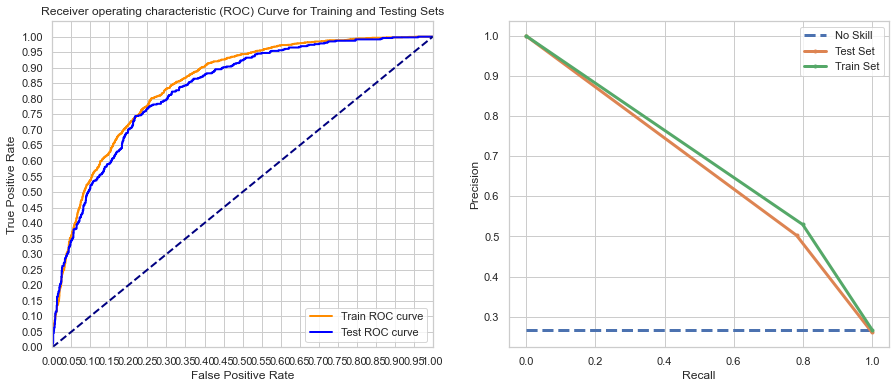

In [70]:
# ROC curve for training set
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='blue',
             lw=lw, label='Test ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(
        'Receiver operating characteristic (ROC) Curve for Training and Testing Sets')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
lw =3
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', lw = lw, label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_hat_test)
train_precision, train_recall, _ = precision_recall_curve(y_train, y_hat_train)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', lw = lw, label='Test Set')
plt.plot(train_recall,train_precision, marker='.',lw=lw, label='Train Set')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()

# show the plot
plt.show()

After I add more parameters into Logical Regression model I received a better result for Recall.

### What happend with model if we remove columns with low weights?

In [53]:
dfs = df.copy()

In [54]:
dfs.drop(['totalcharges','partner_Yes','internetservice_No','onlinebackup_No internet service',
          'deviceprotection_No internet service','deviceprotection_Yes','techsupport_No internet service',
          'streamingtv_No internet service','streamingtv_Yes',
          'paymentmethod_Credit card (automatic)','paymentmethod_Mailed check'],axis=1, inplace=True)
dfs.columns

Index(['tenure', 'monthlycharges', 'churn', 'seniorcitizen_1', 'dependents_Yes', 'multiplelines_No phone service', 'multiplelines_Yes', 'internetservice_Fiber optic', 'onlinebackup_Yes', 'techsupport_Yes', 'contract_One year', 'contract_Two year', 'paperlessbilling_Yes', 'paymentmethod_Electronic check'], dtype='object')

In [55]:
# Split data into X and y
ys=dfs['churn'].copy()

# Define X
Xs = dfs.drop(columns=['churn'], axis=1)

# Split the data into a training and a test set and set stratify=y to help with imbalance data
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, random_state=42)
#-------------
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

-----------------------------------------
Synthetic sample class distribution: 

1    3863
0    3863
Name: churn, dtype: int64


In [72]:
small_smote_logmodel = LogisticRegression(fit_intercept=True, C=0.1,max_iter=200,penalty='l2',random_state=11,
                         solver='liblinear', class_weight='balanced')
small_smote_logmodel.fit(X_train_resampled, y_train_resampled)

#predictions
y_hat_train = small_smote_logmodel.predict(X_train_resampled)
y_hat_test = small_smote_logmodel.predict(X_test)

# Evaluate predictions
print('-'*40)
print('Accuracy score for Training Dataset = ', accuracy_score(y_train_resampled, y_hat_train))
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, y_hat_test))


print('-'*40)
print('------------Confusion Matrix------------')
print('Train set:')
print(confusion_matrix(y_train_resampled, y_hat_train), '\n')
print('Test set:')
print(confusion_matrix(y_test, y_hat_test), '\n')

print('-'*40)
print('Classification Matrix:')
print(classification_report(y_test, y_hat_test))

----------------------------------------
Accuracy score for Training Dataset =  0.7986021227025628
Accuracy score for Testing Dataset =  0.7463026166097838
----------------------------------------
------------Confusion Matrix------------
Train set:
[[2952  911]
 [ 645 3218]] 

Test set:
[[978 322]
 [124 334]] 

----------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1300
           1       0.51      0.73      0.60       458

    accuracy                           0.75      1758
   macro avg       0.70      0.74      0.71      1758
weighted avg       0.79      0.75      0.76      1758



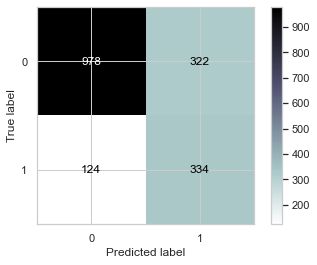

In [73]:
plot_confusion_matrix(small_smote_logmodel, X_test, y_test,cmap='bone_r')  

In [74]:
# Compute Receiver operating characteristic (ROC)
# Calculate the probability scores of each point in the training set
y_train_score = small_smote_logmodel.fit(X_train, y_train).decision_function(X_train)

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

# Calculate the probability scores of each point in the test set
y_test_score = small_smote_logmodel.decision_function(X_test)

# Calculate the fpr, tpr, and thresholds for the test set
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
# probability that a randomly chosen positive instance is ranked higher 
# than a randomly chosen negative instance
print('Training AUC: {}'.format(round(auc(train_fpr, train_tpr), 5)))
print('Testing AUC: {}'.format(round(auc(test_fpr, test_tpr), 5)))

Training AUC: 0.84628
Testing AUC: 0.831


# Decision Tree

In [78]:
# modeling with Decision Tree
#create an instance and fit the model 
treemodel = DecisionTreeClassifier(random_state=123)
treemodel.fit(X_train, y_train)

#predictions
y_hat_train= treemodel.predict(X_train)
y_hat_test = treemodel.predict(X_test)

# Evaluate predictions
print('-'*40)
print('Accuracy score for Training Dataset = ', accuracy_score(y_train, y_hat_train))
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, y_hat_test))


print('-'*40)
print('------------Confusion Matrix------------')
print('Train set:')
print(confusion_matrix(y_train, y_hat_train), '\n')
print('Test set:')
print(confusion_matrix(y_test, y_hat_test), '\n')

print('-'*40)
print('Classification Matrix:')
print(classification_report(y_test, y_hat_test))

----------------------------------------
Accuracy score for Training Dataset =  0.997535077739856
Accuracy score for Testing Dataset =  0.729806598407281
----------------------------------------
------------Confusion Matrix------------
Train set:
[[3860    3]
 [  10 1401]] 

Test set:
[[1052  248]
 [ 227  231]] 

----------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1300
           1       0.48      0.50      0.49       458

    accuracy                           0.73      1758
   macro avg       0.65      0.66      0.65      1758
weighted avg       0.73      0.73      0.73      1758



Accuracy score for Training Dataset = 0.9975 >> then Accuracy score for Testing Dataset = 0.7298 <br> It show us oversampling

In [79]:
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

Original class distribution: 

0    5163
1    1869
Name: churn, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    3863
0    3863
Name: churn, dtype: int64


In [80]:
treemodel = DecisionTreeClassifier(random_state=123)
treemodel.fit(X_train_resampled, y_train_resampled)

#predictions
y_hat_train=treemodel.predict(X_train_resampled)
y_hat_test = treemodel.predict(X_test)

# Evaluate predictions
print('-'*40)
print('Accuracy score for Training Dataset = ', accuracy_score(y_train_resampled, y_hat_train))
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, y_hat_test))


print('-'*40)
print('------------Confusion Matrix------------')
print('Train set:')
print(confusion_matrix(y_train_resampled, y_hat_train), '\n')
print('Test set:')
print(confusion_matrix(y_test, y_hat_test), '\n')

print('-'*40)
print('Classification Matrix:')
print(classification_report(y_test, y_hat_test))

----------------------------------------
Accuracy score for Training Dataset =  0.9983173699197515
Accuracy score for Testing Dataset =  0.714448236632537
----------------------------------------
------------Confusion Matrix------------
Train set:
[[3860    3]
 [  10 3853]] 

Test set:
[[1005  295]
 [ 207  251]] 

----------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1300
           1       0.46      0.55      0.50       458

    accuracy                           0.71      1758
   macro avg       0.64      0.66      0.65      1758
weighted avg       0.73      0.71      0.72      1758



The same problem.

## Random Forest

In [8]:
# split dataset
X = df.drop(['churn'], axis=1)
y = df['churn']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
#Scaling the data by sklearn Standard Scaler
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_train = pd.DataFrame(scaled_x_train, columns=X_train.columns)

In [11]:
# some work with Imbalanced Data:
# - SMOTE()
smote = SMOTE()
scaled_X_train_smoted, y_train_smoted = smote.fit_sample(scaled_X_train, y_train)
# - ADASYN()
adasyn = ADASYN()

In [12]:
randommodel = RandomForestClassifier(max_depth=5, n_jobs=-1, class_weight='balanced', random_state=42)
randommodel.fit(X_train, y_train)

#predictions
y_hat_train=randommodel.predict(X_train)
y_hat_test = randommodel.predict(X_test)

evaluate_predictions(X_train, X_test, y_train, y_test, y_hat_train, y_hat_test)

----------------------------------------
Accuracy score for Training Dataset =  0.7624194160030338
Accuracy score for Testing Dataset =  0.7349260523321957
----------------------------------------
------------Confusion Matrix------------
Train set:
[[2874  989]
 [ 264 1147]] 

Test set:
[[930 370]
 [ 96 362]] 

----------------------------------------
---------Classification Matrix:---------
Train set:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      3863
           1       0.54      0.81      0.65      1411

    accuracy                           0.76      5274
   macro avg       0.73      0.78      0.73      5274
weighted avg       0.81      0.76      0.77      5274
 

Test set:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1300
           1       0.49      0.79      0.61       458

    accuracy                           0.73      1758
   macro avg       0.70      0.75    

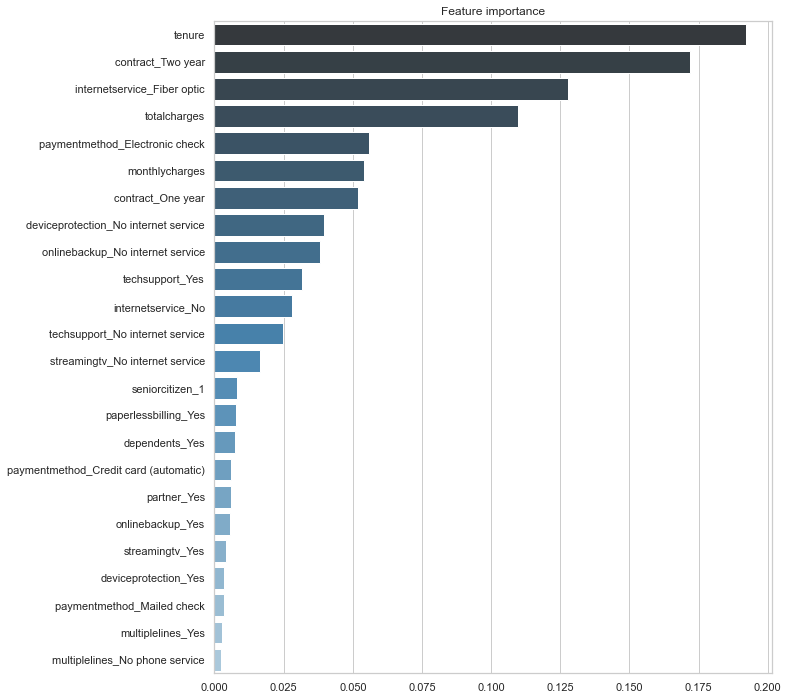

In [13]:
# Plot features importances
imp = pd.Series(data=randommodel.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

Text(0, 0.5, 'Feature')

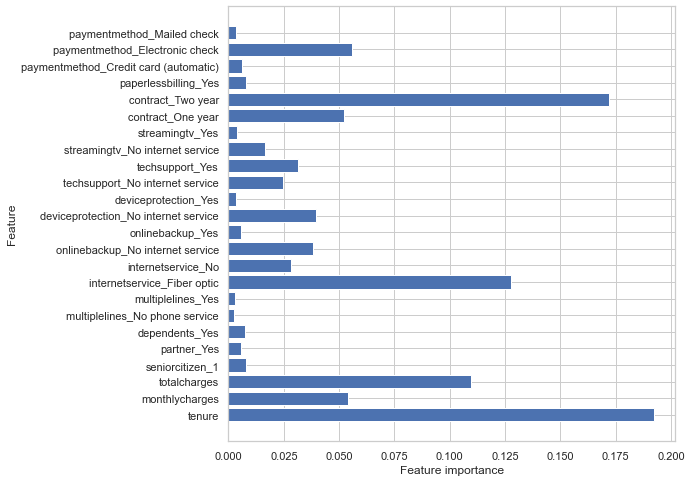

In [14]:
n_features = X_train.shape[1]
plt.figure(figsize=(8, 8))
plt.barh(range(n_features), randommodel.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns.values)
plt.xlabel('Feature importance')
plt.ylabel('Feature')

**Most important features: tenure, Contract Two Year, Internet Service FiberOptic, and Total Charges.**

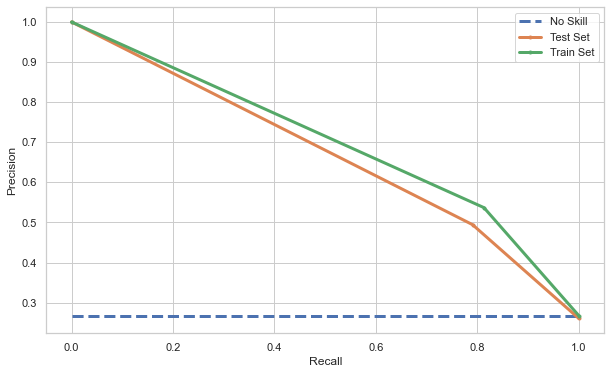

In [95]:
# Precision-Recall Curve
plt.figure(figsize=(10, 6))
lw =3
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', lw = lw, label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_hat_test)
train_precision, train_recall, _ = precision_recall_curve(y_train, y_hat_train)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', lw = lw, label='Test Set')
plt.plot(train_recall,train_precision, marker='.',lw=lw, label='Train Set')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()

# show the plot
plt.show()

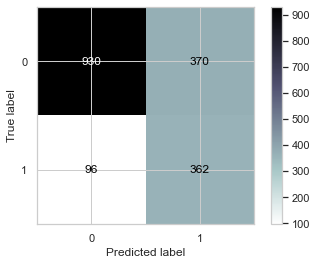

In [20]:
plot_confusion_matrix(randommodel, X_test, y_test,cmap='bone_r')  

### Conclusions
I have a precision of 0.49 (it means 49% of the customers we say 'churn' was true) and recall of 0.79 in the test set for this model. I don't see overfitting. 

----------

## Pipeline

In [111]:
# create pipline for Random Forest Classifier, use only one parameter for it.
pipeline1 = Pipeline([('classifier', RandomForestClassifier())])

In [108]:
RandomForestClassifier.get_params(RandomForestClassifier).keys()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [112]:
# define a grid with parameters for checking
grid = [{'classifier__n_estimators':[5, 10, 20, 50, 100, 150, 200],
         'classifier__criterion': ['gini', 'entropy'],         
         'classifier__max_depth': [3, 4, 5, 6, 7, 8],
         'classifier__min_samples_split': [1.0, 2, 3, 4, 5, 6, 7, 8, 9, 10],
         'classifier__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
         'classifier__class_weight':['balanced']}]

In [113]:
rfc = GridSearchCV(estimator=pipeline1, param_grid=grid, cv=5, scoring='roc_auc', n_jobs=-1)
rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

In [120]:
evaluate_predictions(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

----------------------------------------
Accuracy score for Training Dataset =  0.7624194160030338
Accuracy score for Testing Dataset =  0.7349260523321957
----------------------------------------
------------Confusion Matrix------------
Train set:
[[2874  989]
 [ 264 1147]] 

Test set:
[[930 370]
 [ 96 362]] 

----------------------------------------
---------Classification Matrix:---------
Train set:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      3863
           1       0.54      0.81      0.65      1411

    accuracy                           0.76      5274
   macro avg       0.73      0.78      0.73      5274
weighted avg       0.81      0.76      0.77      5274
 

Test set:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1300
           1       0.49      0.79      0.61       458

    accuracy                           0.73      1758
   macro avg       0.70      0.75    

In [116]:
print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))

0.8865282818166422
0.832013772253947


In [118]:
rfc.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 8,
 'classifier__min_samples_leaf': 6,
 'classifier__min_samples_split': 3,
 'classifier__n_estimators': 50}

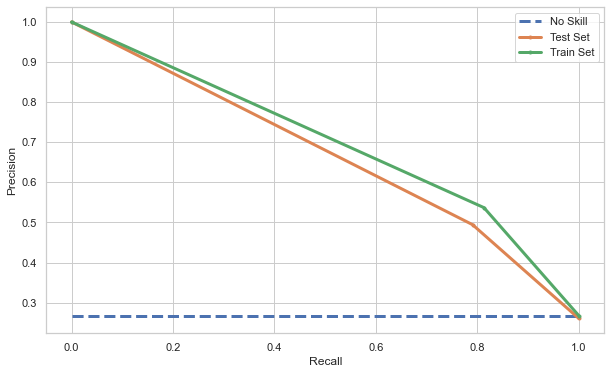

In [119]:
# Precision-Recall Curve
plt.figure(figsize=(10, 6))
lw =3
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', lw = lw, label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_hat_test)
train_precision, train_recall, _ = precision_recall_curve(y_train, y_hat_train)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', lw = lw, label='Test Set')
plt.plot(train_recall,train_precision, marker='.',lw=lw, label='Train Set')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()

# show the plot
plt.show()

### Conclusions
I have a precision of 0.49 (it means 49% of the customers we say 'churn' was true) and recall of 0.79 in the test set for this model. I don't see overfitting.
Pipeline helps prevent data leakage and to have clean code.

------------

# SVM (Support Vector Classification)

In [16]:
# use grid search and class_weight = 'balanced'
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              # use gamma which works only with this tree kernel
              #'kernel': ['poly', 'rbf', 'sigmoid'] 
              'kernel':['rbf']
             }

svm = GridSearchCV(SVC(class_weight = 'balanced'), param_grid, refit=True)

svm.fit(scaled_X_train, y_train)
y_hat_train = svm.predict(scaled_X_train)
y_hat_test = svm.predict(scaled_X_test)
svm.best_params_

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

Result of GridSearchCV:
{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

In [18]:
evaluate_predictions(X_train, X_test, y_train, y_test, y_hat_train, y_hat_test)

----------------------------------------
Accuracy score for Training Dataset =  0.7927569207432689
Accuracy score for Testing Dataset =  0.7753128555176336
----------------------------------------
------------Confusion Matrix------------
Train set:
[[3652  211]
 [ 882  529]] 

Test set:
[[1224   76]
 [ 319  139]] 

----------------------------------------
---------Classification Matrix:---------
Train set:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87      3863
           1       0.71      0.37      0.49      1411

    accuracy                           0.79      5274
   macro avg       0.76      0.66      0.68      5274
weighted avg       0.78      0.79      0.77      5274
 

Test set:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1300
           1       0.65      0.30      0.41       458

    accuracy                           0.78      1758
   macro avg       0.72      0.62

In [25]:
print(svm.score(X_train, y_train))
print(svm.score(X_test, y_test))

0.7324611300720516
0.7394766780432309


## Interpreting the results of the SVM model
We have a precision of 0.65 and recall of 0.30 in the test set.

Accuracy: 0.7929465301478953 

tenure                                   0.213377
monthlycharges                           0.086011
totalcharges                             0.141261
seniorcitizen_1                          0.010166
partner_Yes                              0.005668
dependents_Yes                           0.008046
multiplelines_No phone service           0.003389
multiplelines_Yes                        0.007539
internetservice_Fiber optic              0.117493
internetservice_No                       0.020938
onlinebackup_No internet service         0.021145
onlinebackup_Yes                         0.010492
deviceprotection_No internet service     0.021964
deviceprotection_Yes                     0.005224
techsupport_No internet service          0.022353
techsupport_Yes                          0.033811
streamingtv_No internet service          0.021225
streamingtv_Yes                          0.006290
contract_One year                        0.047622
contract_Two year  

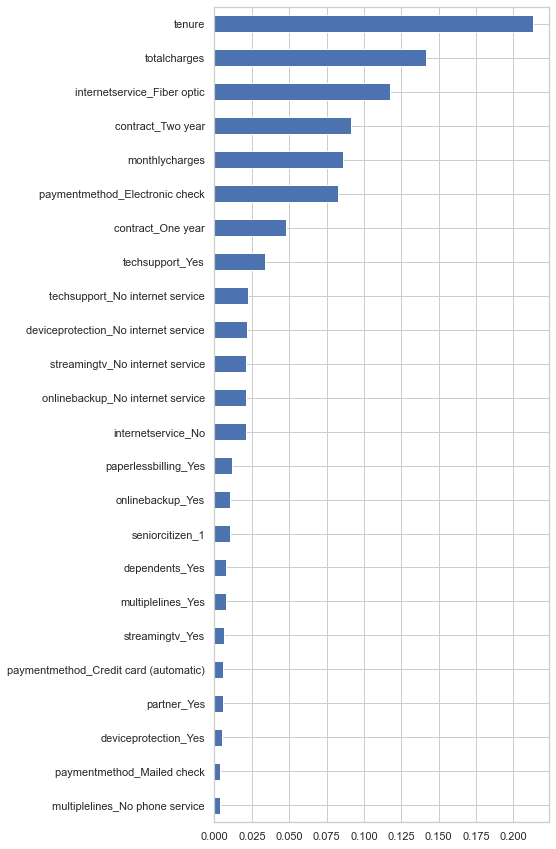

In [86]:
rf = RandomForestClassifier(n_estimators=1000,
                            oob_score = True,
                            n_jobs = -1,
                            random_state =50,
                            max_features = "auto",
                            max_leaf_nodes = 30)
rf.fit(X_train, y_train)

# Make predictions
pred_rf = rf.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_test, pred_rf), '\n')
importances = rf.feature_importances_
weights_RanFor = pd.Series(importances,
                 index=X.columns.values)
print(weights_RanFor)
plt.figure(figsize=(6, 15))
weights_RanFor.sort_values().plot(kind = 'barh')

From random forest algorithm, monthly contract, tenure and total charges are the most important predictor variables to predict churn.
The results from random forest are very similar to that of the logistic regression and in line to what we had expected from our EDA

# AdaBoost Classifier

In [ ]:
model_AdaB = AdaBoostClassifier()
model_AdaB.fit(X_train,y_train)
preds_adaB = model_AdaB.predict(X_test)
metrics.accuracy_score(y_test, preds_adaB)
print('Accuracy:', metrics.accuracy_score(y_test, preds_adaB), '\n')
importances = model_AdaB.feature_importances_
weights_AdaB = pd.Series(importances,
                 index=X.columns.values)
print(weights_AdaB)
plt.figure(figsize=(6, 15))
weights_AdaB.sort_values().plot(kind = 'barh')

In [30]:
model_svm = SVC(kernel='linear') 
model_svm.fit(X_train, y_train)
pred_svm = model_svm.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_test, pred_svm), '\n')

feature_importance = list(zip(model_svm.coef_[0], X.columns.values))
print(feature_importance)

Accuracy: 0.7832764505119454 

[(-0.012623766631350009, 'tenure'), (0.06671007564855813, 'monthlycharges'), (-0.0034104732508239977, 'totalcharges'), (1.454927805175437, 'seniorcitizen_1'), (0.3045101269910333, 'partner_Yes'), (-0.5472648802912659, 'dependents_Yes'), (1.9240930792112962, 'multiplelines_No phone service'), (0.36809671881079, 'multiplelines_Yes'), (0.9264180151639749, 'internetservice_Fiber optic'), (0.2940712507001848, 'internetservice_No'), (0.2940712507001848, 'onlinebackup_No internet service'), (-0.6700722237223147, 'onlinebackup_Yes'), (0.2940712507001848, 'deviceprotection_No internet service'), (-0.0382108949247737, 'deviceprotection_Yes'), (0.2940712507001848, 'techsupport_No internet service'), (-1.6708270760317987, 'techsupport_Yes'), (0.2940712507001848, 'streamingtv_No internet service'), (1.3822152353075268, 'streamingtv_Yes'), (-6.477302952710616, 'contract_One year'), (-17.495046041914428, 'contract_Two year'), (0.32353667258446706, 'paperlessbilling_Yes'

With SVM-Linear Kernel, I am able to achieve the slightly higher than all accuracy on test data to almost 80.19%.